In [1]:
import mne
import os
import numpy as np
from mne.preprocessing import ICA
from pathlib import Path

### Setup

In [2]:
def find_recordings(path):
    """
    This function makes it easy to find the right recording subdirectories
    """
    subdirs = os.listdir(path)
    for subdir in subdirs:
        # the recording folders have messy names, but they all start with 04
        if "04" in subdir: 
            return subdir
        else:
            continue

In [3]:
old_pp_path = "/Volumes/BCOM/BCOM/DATA_ANALYZED/PREPROCESSED"
raw_path = "/Volumes/BCOM/BCOM/DATA_RAW"
processed_path = "/Volumes/BCOM/ciprian_project/data_analyzed"
os.makedirs(processed_path, exist_ok=True)


subjects = [name for name in os.listdir(old_pp_path) if "BCOM" in name] # only the subjects that were deemed good to look at
blocks = [2, 3, 4] # block names
print(subjects)

pdf_suffix = "c,rfDC"
config_suffix = "config"
header_suffix = "hs_file"


# get all of the block recordings            
raw_paths = [os.path.join(raw_path, f"{subject}/MEG/{subject}/BCom/") for subject in subjects]
raw_paths = [os.path.join(raw_path, f"{find_recordings(raw_path)}") for raw_path in raw_paths]
parsed_paths = [os.path.join(raw_path, str(block)) for raw_path in raw_paths for block in blocks]

# just in case
assert len(parsed_paths) == 63
assert all(".DS_Store" not in path for path in parsed_paths)

['BCOM_13', 'BCOM_21', 'BCOM_12', 'BCOM_10', 'BCOM_16', 'BCOM_18', 'BCOM_09', 'BCOM_26', 'BCOM_14', 'BCOM_23', 'BCOM_01', 'BCOM_02', 'BCOM_08', 'BCOM_19', 'BCOM_15', 'BCOM_24', 'BCOM_07', 'BCOM_04', 'BCOM_11', 'BCOM_06', 'BCOM_22']


In [4]:
# get all of the empty room recordings
empty_room_paths = [os.path.join(raw_path, f"{subject}/MEG/{subject}/emp_sup_v1") for subject in subjects]
empty_room_paths = [os.path.join(raw_path, f"{find_recordings(raw_path)}/2") for raw_path in empty_room_paths]

assert len(empty_room_paths) == 21

In [5]:
# Group together empty rooms and subject blocks so that we can apply the transformations properly
raw_empty_paired = [
    (parsed_paths[i:i+3], empty_room_paths[i // 3]) for i in range(0, len(parsed_paths), 3)
]

# example
print(raw_empty_paired[0])
print("\n")
print(raw_empty_paired[0][0])
print(f"length:{len(raw_empty_paired[0][0])}")
print("\n")
print(raw_empty_paired[0][1])

(['/Volumes/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/2', '/Volumes/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/3', '/Volumes/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/4'], '/Volumes/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/emp_sup_v1/04%19%19@02_20/2')


['/Volumes/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/2', '/Volumes/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/3', '/Volumes/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/4']
length:3


/Volumes/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/emp_sup_v1/04%19%19@02_20/2


### Processing setup

In [14]:
# code from Remy
def get_flats(raw, flat_criteria, duration, id, start):
    """
    This function finds and flat channels and returns them as a list
    """
    events_tmp = mne.make_fixed_length_events(raw, duration=duration, id=id, start=start)
    epochs_tmp = mne.Epochs(raw, events=events_tmp, event_id=id, flat=flat_criteria, verbose=False)
    epochs_tmp.load_data()
    
    flat_channels = []
    
    if epochs_tmp.drop_log_stats()>0:
        flat_channels=list(set([ch for chs in epochs_tmp.drop_log for ch in chs]))
    del epochs_tmp

    return flat_channels

def path_parser_local(path):
    """
    This function returns the relevant parts of the path
    to make saving things easier
    """
    path = Path(path) 
    
    path_parts = path.parts
    
    subject = path_parts[5]
    block = path_parts[-1]
    
    subject_block = os.path.join(subject, block)
    
    return subject_block
    

In [ ]:
# filtering params, from MNE best practices
lowpass_filter = 150.0 #to get freq up to 150
highpass_filter = 0.5
sampling_rate = 500

# detecting flat channels
flat_criteria= dict(mag=1e-13)
duration=3
id=1
start=2

# ICA setup
ica_method = 'fastica'
n_components = 0.97
decim = 3
random_state = 23
reject = dict(mag=1e-11)

# noth filtering freqs
notch_freqs=(50, 100, 150)

### Start processing

Reading 4D PDF file /Volumes/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/emp_sup_v1/04%19%19@02_20/2/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... putting coil transforms in Neuromag coordinates
... no headshape file supplied, doing nothing.
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Reading 0 ... 366211  =      0.000 ...   180.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.9s


LOF: Detected bad channel(s): ['MEG 132', 'MEG 214']
Using data from preloaded Raw for 59 events and 1425 original time points ...
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059'

/var/folders/f1/tvmmnqs17399g3n7wyy0pq0c0000gn/T/ipykernel_1653/2035425827.py:8: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs_tmp.load_data()
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.9s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 13429 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.8s


Reading 4D PDF file /Volumes/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/2/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... putting coil transforms in Neuromag coordinates
... Reading digitization points from /Volumes/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/2/hs_file
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Reading 0 ... 1166031  =      0.000 ...   573.126 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    3.2s


LOF: Detected bad channel(s): []
Using data from preloaded Raw for 190 events and 1425 original time points ...
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Re

/var/folders/f1/tvmmnqs17399g3n7wyy0pq0c0000gn/T/ipykernel_1653/2035425827.py:8: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs_tmp.load_data()
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    3.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 13429 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    3.0s


Trigger channel STI 014 has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1053 events found on stim channel STI 014
Event IDs: [  2   4  12  14  16  22  24  26  32  34  36  42  44  46  52  54  56  62
  64  66 112 114 116 122 124 126 132 134 136 142 144 146 152 154 156 162
 164 166 512 514 516 524 526 528 534 536 538 544 546 548 554 556 558 564
 566 568 574 576 578 624 626 628 634 636 638 644 646 648 654 656 658 664
 666 668 674 676 678]
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.5s


Fitting ICA to data using 246 channels (please be patient, this may take a while)
    Rejecting  epoch based on MAG : ['MEG 115', 'MEG 116', 'MEG 117', 'MEG 146', 'MEG 147', 'MEG 148', 'MEG 149', 'MEG 150', 'MEG 153', 'MEG 154', 'MEG 155', 'MEG 174', 'MEG 175', 'MEG 176', 'MEG 177', 'MEG 178', 'MEG 179', 'MEG 193', 'MEG 194', 'MEG 195', 'MEG 196', 'MEG 211', 'MEG 212', 'MEG 213', 'MEG 227', 'MEG 228', 'MEG 229', 'MEG 230', 'MEG 231', 'MEG 246', 'MEG 247', 'MEG 248']
Artifact detected in [19706, 20040]
    Rejecting  epoch based on MAG : ['MEG 113', 'MEG 114', 'MEG 144', 'MEG 145', 'MEG 146']
Artifact detected in [24716, 25050]
    Rejecting  epoch based on MAG : ['MEG 153', 'MEG 154', 'MEG 155', 'MEG 156', 'MEG 174', 'MEG 175', 'MEG 176', 'MEG 177', 'MEG 178', 'MEG 179', 'MEG 193', 'MEG 194', 'MEG 195', 'MEG 196', 'MEG 197', 'MEG 210', 'MEG 211', 'MEG 212', 'MEG 213', 'MEG 227', 'MEG 228', 'MEG 229', 'MEG 230', 'MEG 231', 'MEG 232', 'MEG 245', 'MEG 246', 'MEG 247', 'MEG 248']
Artifact 

/opt/homebrew/Caskroom/miniconda/base/envs/mne/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 83.0s.


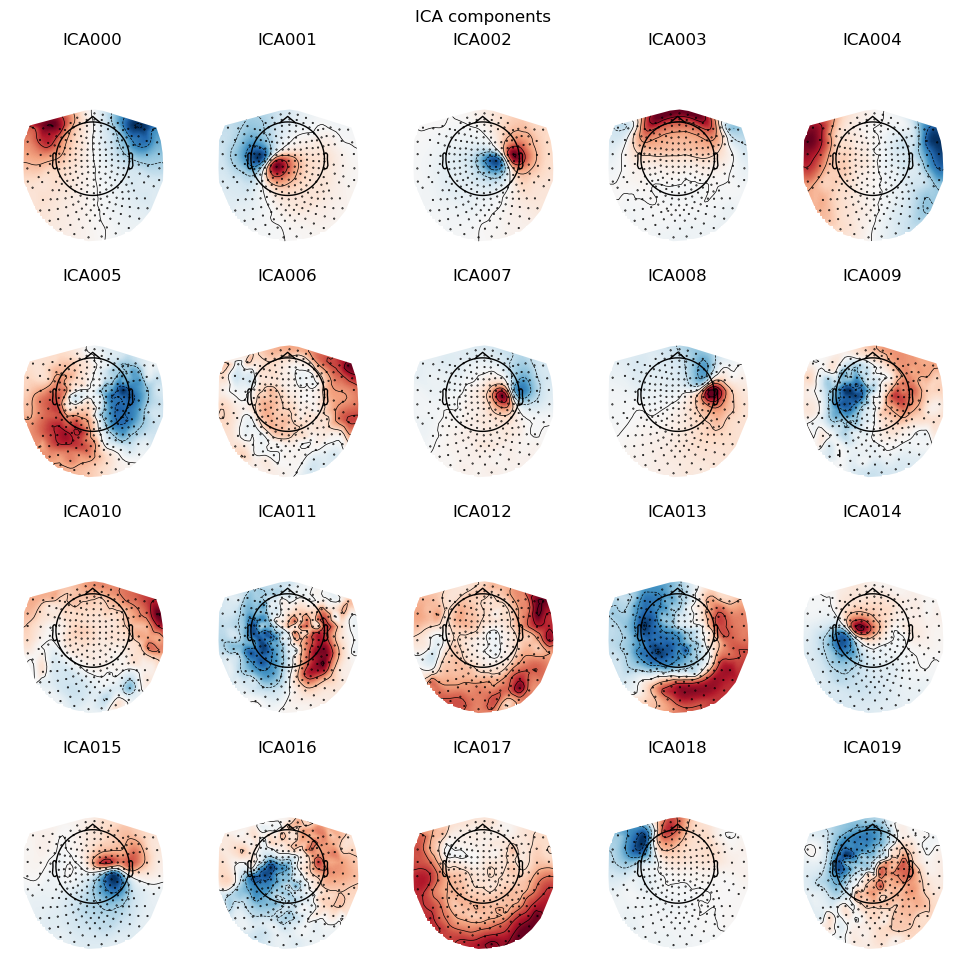

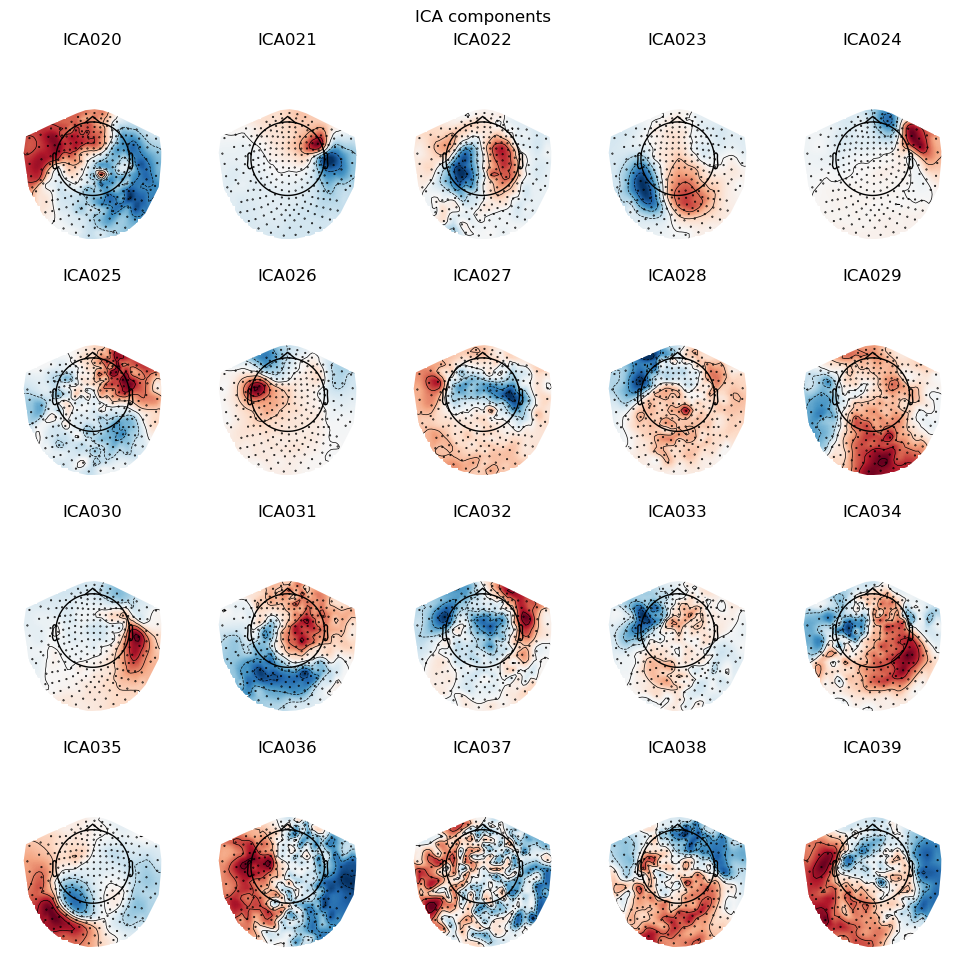

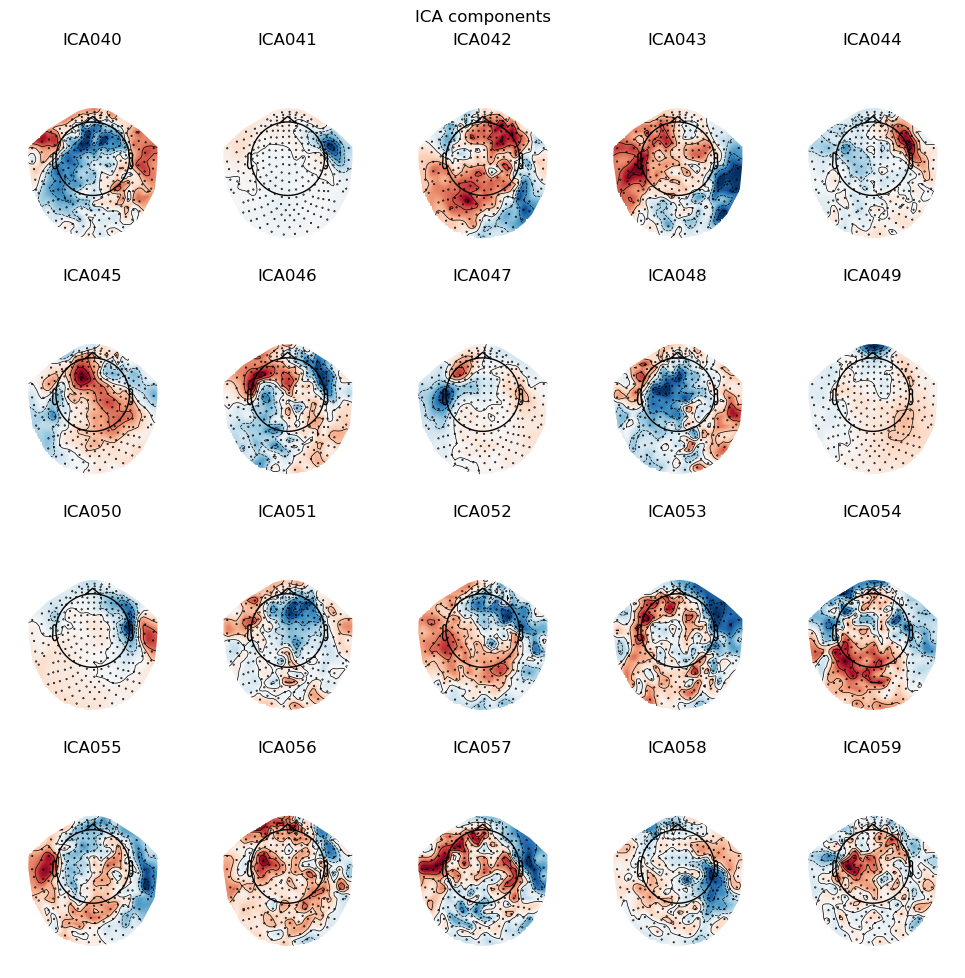

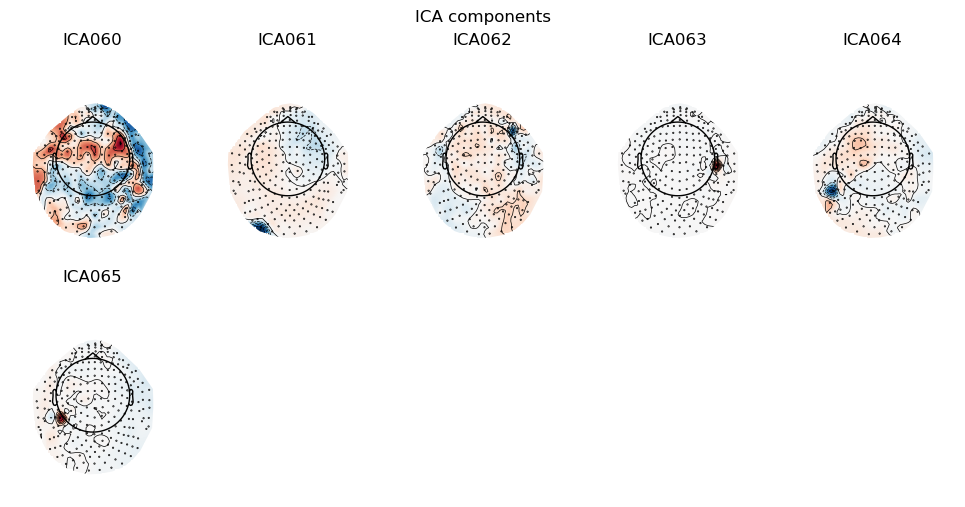

Creating RawArray with float64 data, n_channels=69, n_times=286563
    Range : 0 ... 286562 =      0.000 ...   573.124 secs
Ready.
Using pyopengl with version 3.1.6


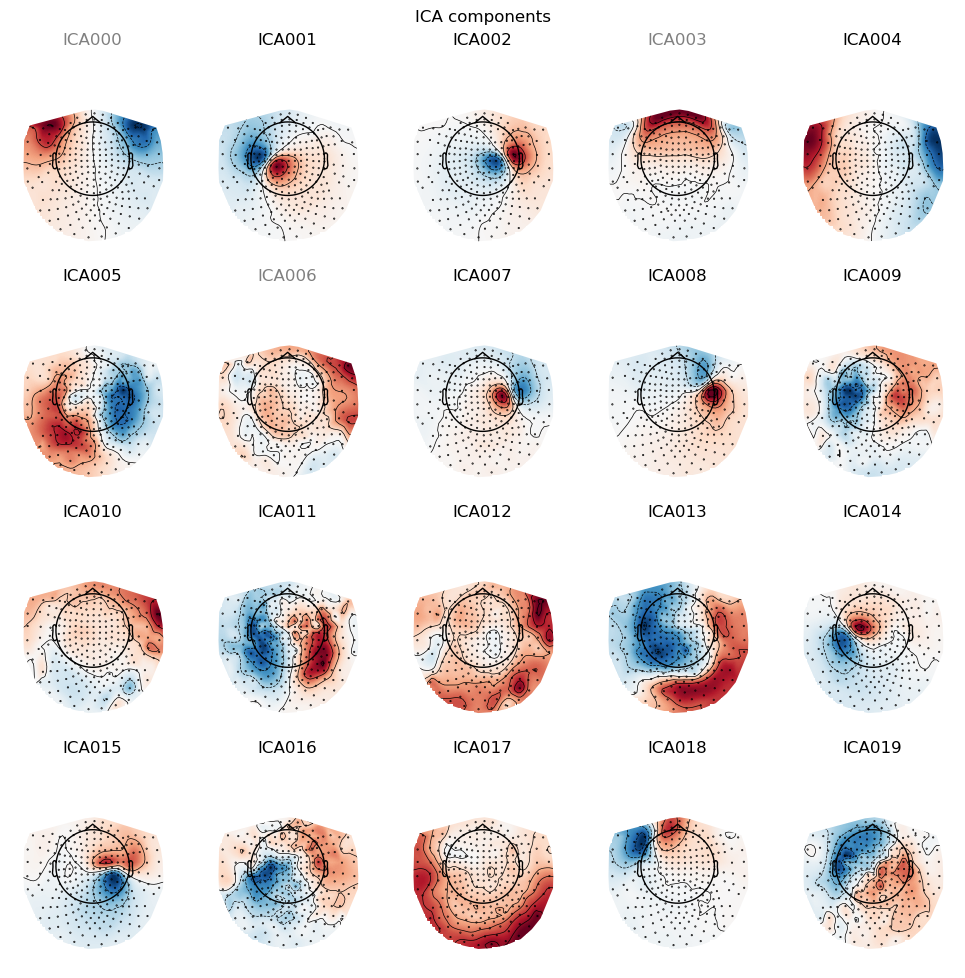

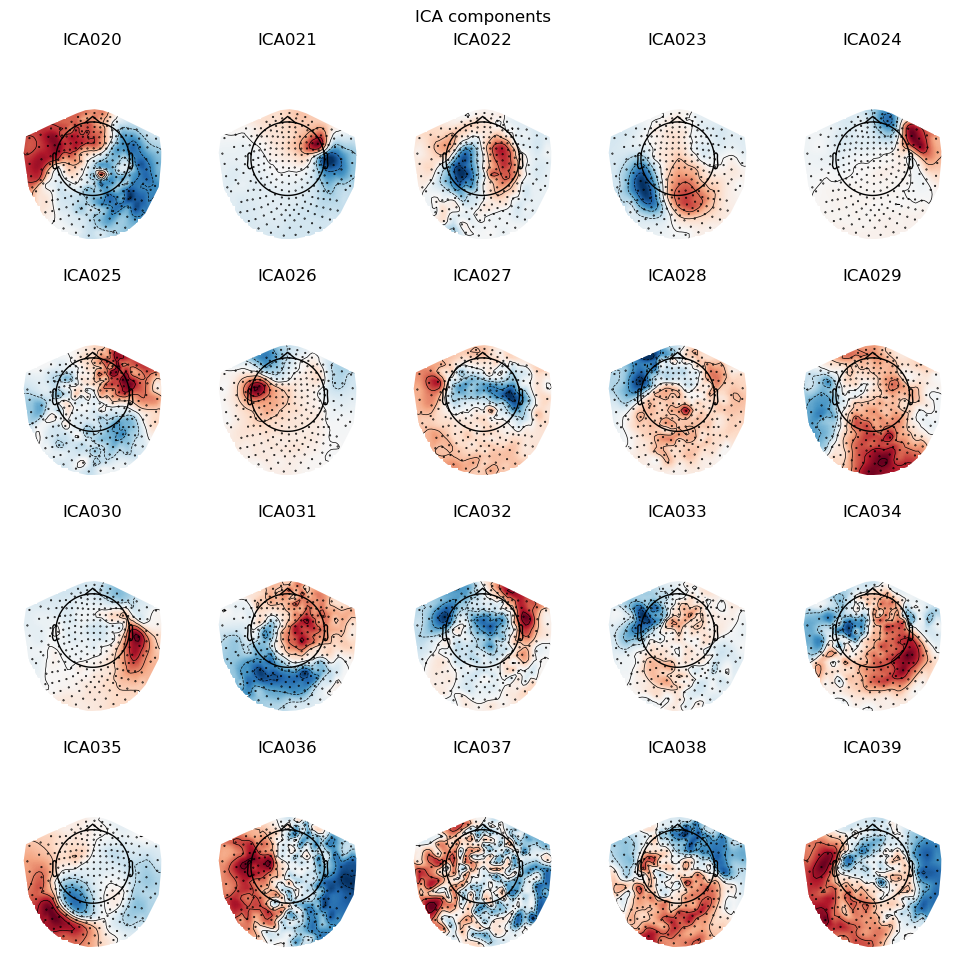

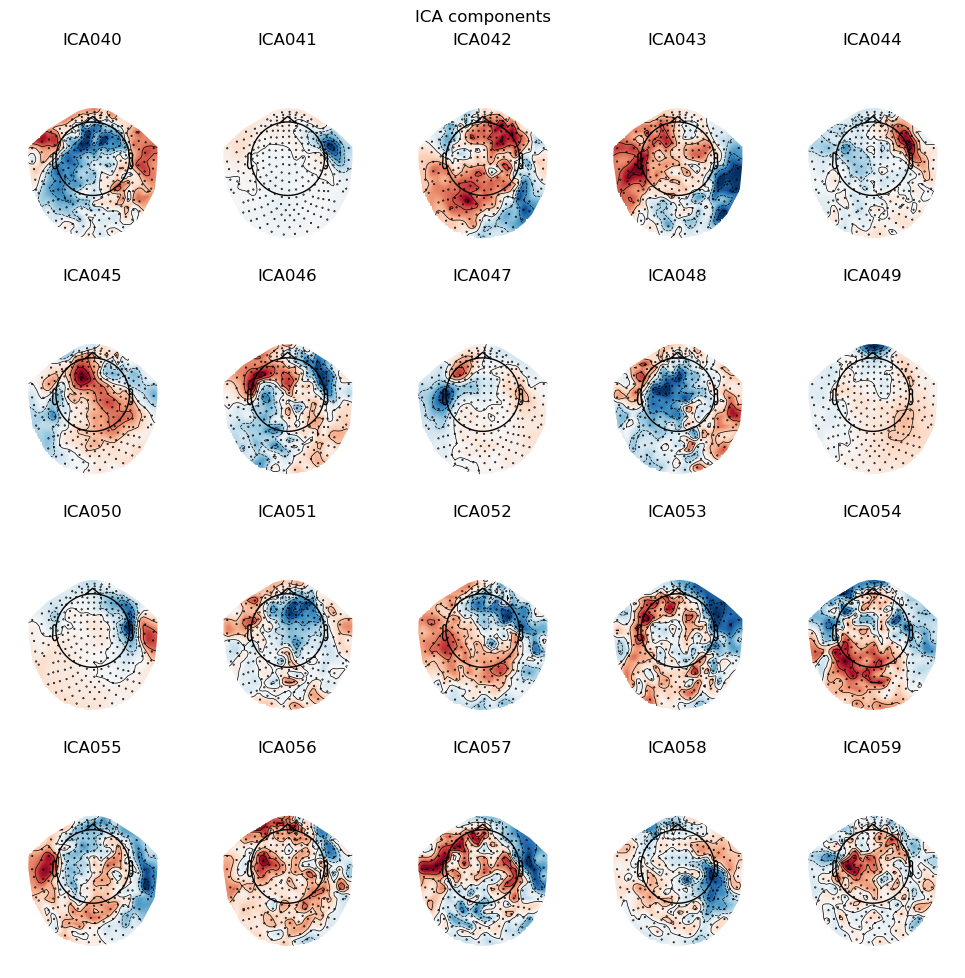

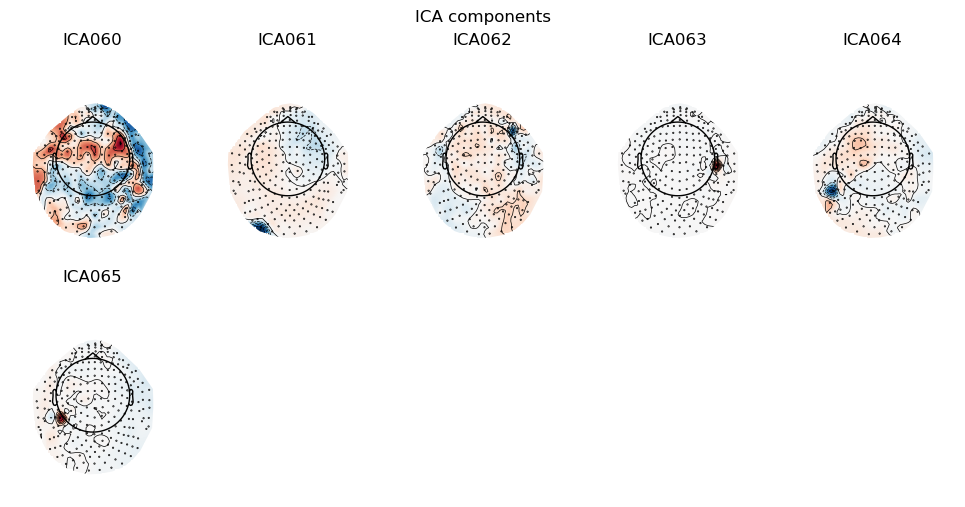

ica plotted
[6, 3, 0]
    Rejecting  epoch based on MAG : ['MEG 114', 'MEG 115', 'MEG 116', 'MEG 117', 'MEG 118', 'MEG 126', 'MEG 127', 'MEG 146', 'MEG 147', 'MEG 148', 'MEG 149', 'MEG 150', 'MEG 153', 'MEG 154', 'MEG 155', 'MEG 156', 'MEG 172', 'MEG 174', 'MEG 175', 'MEG 176', 'MEG 177', 'MEG 178', 'MEG 179', 'MEG 193', 'MEG 194', 'MEG 195', 'MEG 196', 'MEG 210', 'MEG 211', 'MEG 212', 'MEG 213', 'MEG 227', 'MEG 228', 'MEG 229', 'MEG 230', 'MEG 231', 'MEG 246', 'MEG 247', 'MEG 248']
Artifact detected in [59000, 60000]
    Rejecting  epoch based on MAG : ['MEG 112', 'MEG 113', 'MEG 114', 'MEG 144', 'MEG 145', 'MEG 146']
Artifact detected in [74000, 75000]
    Rejecting  epoch based on MAG : ['MEG 127', 'MEG 146', 'MEG 147', 'MEG 148', 'MEG 149', 'MEG 150', 'MEG 153', 'MEG 154', 'MEG 155', 'MEG 156', 'MEG 157', 'MEG 174', 'MEG 175', 'MEG 176', 'MEG 177', 'MEG 178', 'MEG 179', 'MEG 193', 'MEG 194', 'MEG 195', 'MEG 196', 'MEG 197', 'MEG 210', 'MEG 211', 'MEG 212', 'MEG 213', 'MEG 227', 'ME

IndexError: index 276 is out of bounds for axis 0 with size 266

In [ ]:
for i, pairs in enumerate(raw_empty_paired):
    
    subject_raw_paths = pairs[0]
    empty_room_path = pairs[1]    
    
    empty_room_pdf_name=os.path.join(empty_room_path, pdf_suffix)
    empty_room_config_name=os.path.join(empty_room_path, config_suffix)
    
    empty_room_raw = mne.io.read_raw_bti(
        pdf_fname=empty_room_pdf_name,
        config_fname=empty_room_config_name,
        head_shape_fname=None,
        rename_channels=True,
        sort_by_ch_name=True,
        ecg_ch="ECG",
        eog_ch=("EOGv", "EOGh"),    
        preload=True,
    )
    
    noisy_channels_empty_room = mne.preprocessing.find_bad_channels_lof(
        empty_room_raw
        .copy()
        .pick("meg")
        .filter(1,100) # the idea here is to remove slow drift to keep channels that might be eroneously removed
        )
    
    flat_channels_empty_room = get_flats(
        raw=empty_room_raw,
        flat_criteria=flat_criteria,
        duration=duration,
        id=id,
        start=start
    )
    
    bad_channels_empty_room = noisy_channels_empty_room + flat_channels_empty_room
    
    print(bad_channels_empty_room)
    
    empty_room_raw.info['bads'] = bad_channels_empty_room

    empty_room_raw.notch_filter(freqs=notch_freqs) # check about that weird thing in 46
    
    filtered_empty_room_raw = empty_room_raw.copy().filter(l_freq=highpass_filter, h_freq=lowpass_filter)
    
    resampled_empty_room_raw = filtered_empty_room_raw.resample(sfreq=sampling_rate)
    
    for block in subject_raw_paths:
        
        # path parsing for saving later
        subject_block = path_parser_local(block)
        data_path = os.path.join(processed_path, subject_block)
        ica_path = os.path.join(data_path, "ICA")
        
        for path in [data_path, ica_path]:
            os.makedirs(path, exist_ok=True)
            
        
        # get file names
        subject_pdf_fname=os.path.join(block, pdf_suffix)
        subject_config_fname=os.path.join(block, config_suffix)
        subject_head_shape_fname=os.path.join(block, header_suffix)
        
#         print(empty_room_pdf_name)
#         print(empty_room_config_name)
#         print(subject_pdf_fname)
#         print(subject_config_fname)
#         print(subject_head_shape_fname)
        
        subject_raw = mne.io.read_raw_bti(
            pdf_fname=subject_pdf_fname,
            config_fname=subject_config_fname,
            head_shape_fname=subject_head_shape_fname,
            rename_channels=True,
            sort_by_ch_name=True,
            ecg_ch="ECG",
            eog_ch=("EOGv", "EOGh"),    
            preload=True,
        )
        
        noisy_channels_subject = mne.preprocessing.find_bad_channels_lof(
            subject_raw
            .copy()
            .pick("meg")
            .filter(1,100) # the idea here is to remove slow drift to keep channels that might be eroneously removed
        )
        
        flat_channels_subject = get_flats(
            raw=subject_raw, 
            flat_criteria=flat_criteria,
            duration=duration,
            id=id,
            start=start
        )
        
        bad_channels_subject = noisy_channels_subject + flat_channels_subject
        
        print(bad_channels_subject)

        subject_raw.info['bads'] = bad_channels_subject

        subject_raw.notch_filter(freqs=notch_freqs)
        
        filtered_subject_raw = subject_raw.copy().filter(l_freq=highpass_filter, h_freq=lowpass_filter)
        
        subject_events = mne.find_events(filtered_subject_raw, shortest_event=1)
        
        resampled_subject_raw, resampled_subject_events = filtered_subject_raw.resample(
            sfreq=sampling_rate, 
            events=subject_events
        )
        
        ica_subject = ICA(n_components=n_components, # can use None for better explanation but that takes forever
          method=ica_method,
          random_state=random_state,
        )
        
        # highpass filter at 1 so that the drift doesnt take all the variance - see MNE docs
        subject_raw_ica = resampled_subject_raw.copy().filter(1,None)
        
        ica_subject.fit(
            subject_raw_ica,
            picks='meg',
            decim=decim,
            reject=reject
        ) 
        
        # plotting for manual rejection
        ica_subject.plot_components()
        ica_subject.plot_sources(resampled_subject_raw, block=True)
        
        # saving the ica plot
        for f in ica_subject.plot_components():
            
            part_1 = f.get_children()[1].get_label()[-2:]
            part_2 = f.get_children()[-2].get_label()[-2:]
            string = "_ICA_comps.png"
            dpi = 300
            
            filename = part_1 + "_" + part_2 + string
            
            f.savefig(
                os.path.join(ica_path, filename),
                dpi=dpi
            )
        print("ica plotted")
        print(ica_subject.exclude)
        
        # save the excluded components
        
        for i, f in enumerate(ica_subject.plot_properties(resampled_subject_raw, picks=ica_subject.exclude)):
            
            filename=f"removed_comp_{i}.png"
            dpi=300
            
            f.savefig(
                os.path.join(ica_path, filename),
                dpi=dpi
            )
        print("excluded components plotted")
        
        # save ICA solution, with the exclude property populated
        ica_subject.save(os.path.join(ica_path, "solution_ica.fif"))
        
        ica_subject.apply(resampled_subject_raw)
        
        # IMPORTANT! we want a different solution applied each time, so copy in the filtered empty room
        resampled_empty_room_raw_copy = resampled_empty_room_raw.copy()
        
        ica_subject.apply(resampled_empty_room_raw_copy)
        
        # get the union of the bads so that the .info['bads'] are the same for both 
        bads_union = list(set(bad_channels_subject).union(set(bad_channels_empty_room))) 
        
        
        # make sure they have the same bads
        resampled_subject_raw.info['bads'] = bads_union
        resampled_empty_room_raw_copy.info['bads'] = bads_union
        
        # save the objects
        # NB! note there is no interpolation here. Better to interpolate during the epoching stage
        # since that is analysis based
        
        resampled_subject_raw.save(os.path.join(data_path, "subject_cleaned_raw.fif"), overwrite=True)
        resampled_empty_room_raw_copy.save(os.path.join(data_path, "empty_room_cleaned_raw.fif"), overwrite=True)
        np.save("resampled_events.npy", resampled_subject_events)
        
        del resampled_subject_raw
        del resampled_empty_room_raw_copy
        
        break
        
    break
    

Effective window size : 1.007 (s)


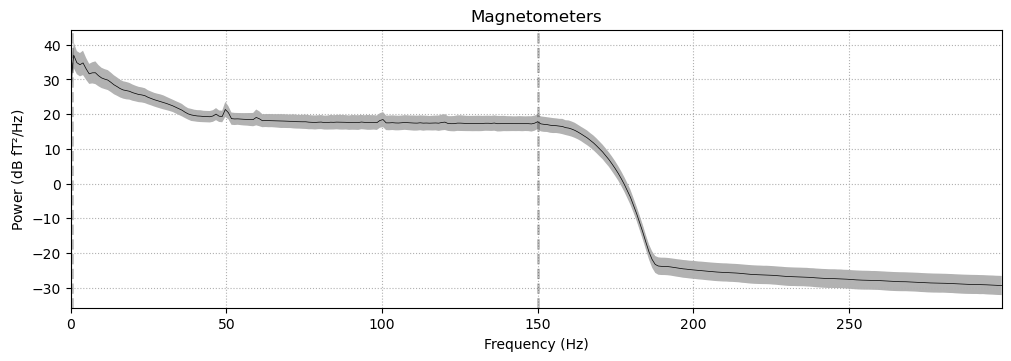

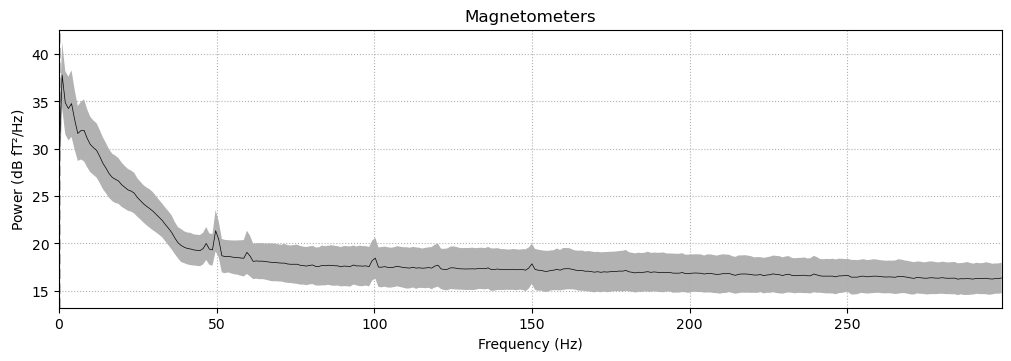

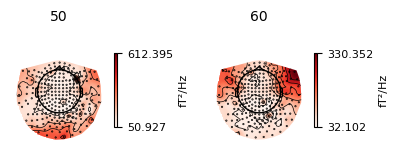

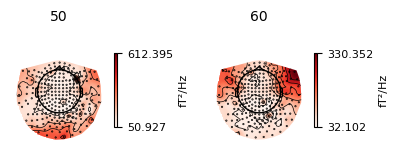

In [ ]:
# # question here, should there be a notch filter in the pipeline? seems to be environmental noise at 50 and 60Hz. 
# # might be fine because we can do baseline normalization in the TF domain to iron out any noise at these frequencies
# sample_raw.compute_psd(tmax = np.inf, fmax=300.0).plot_topomap(
#     {"50": (49, 51),
#      "60": (59, 61)}
# )

In [19]:
# filtered_raw.compute_psd(tmax=np.inf, fmax=150.0).plot(average=True, amplitude=False, exclude="bads")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.2s


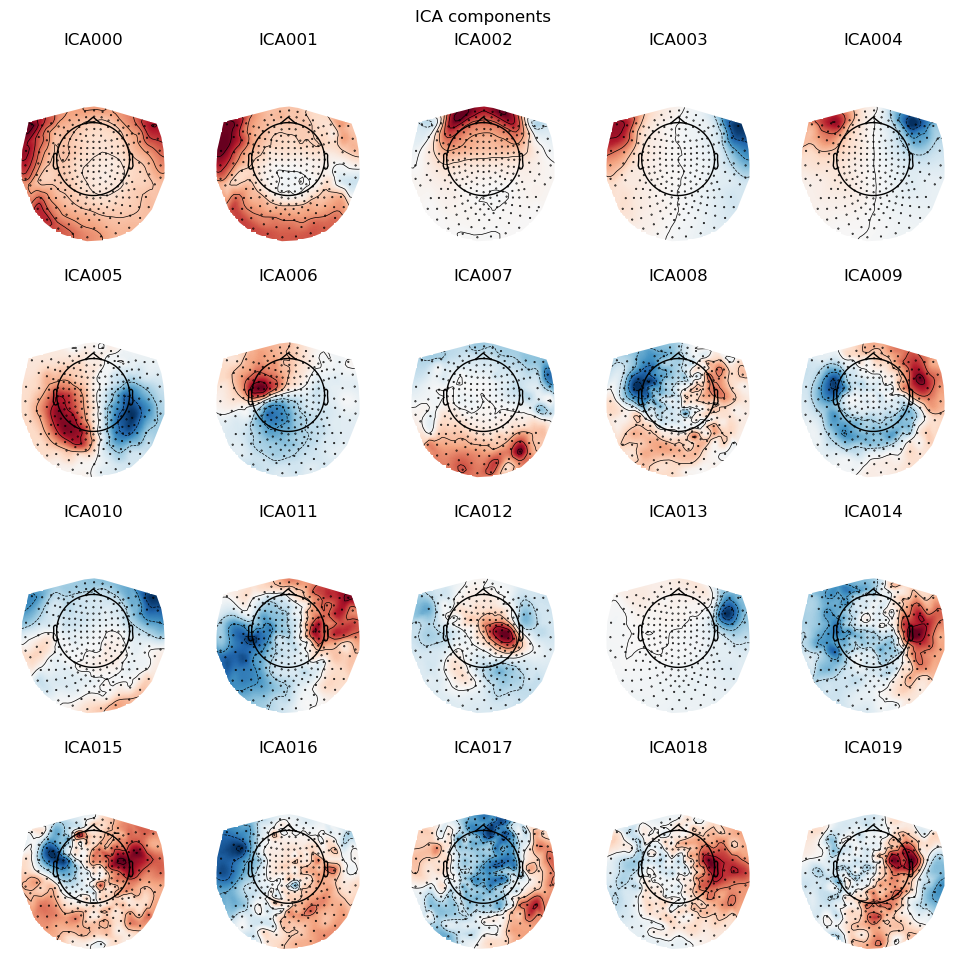

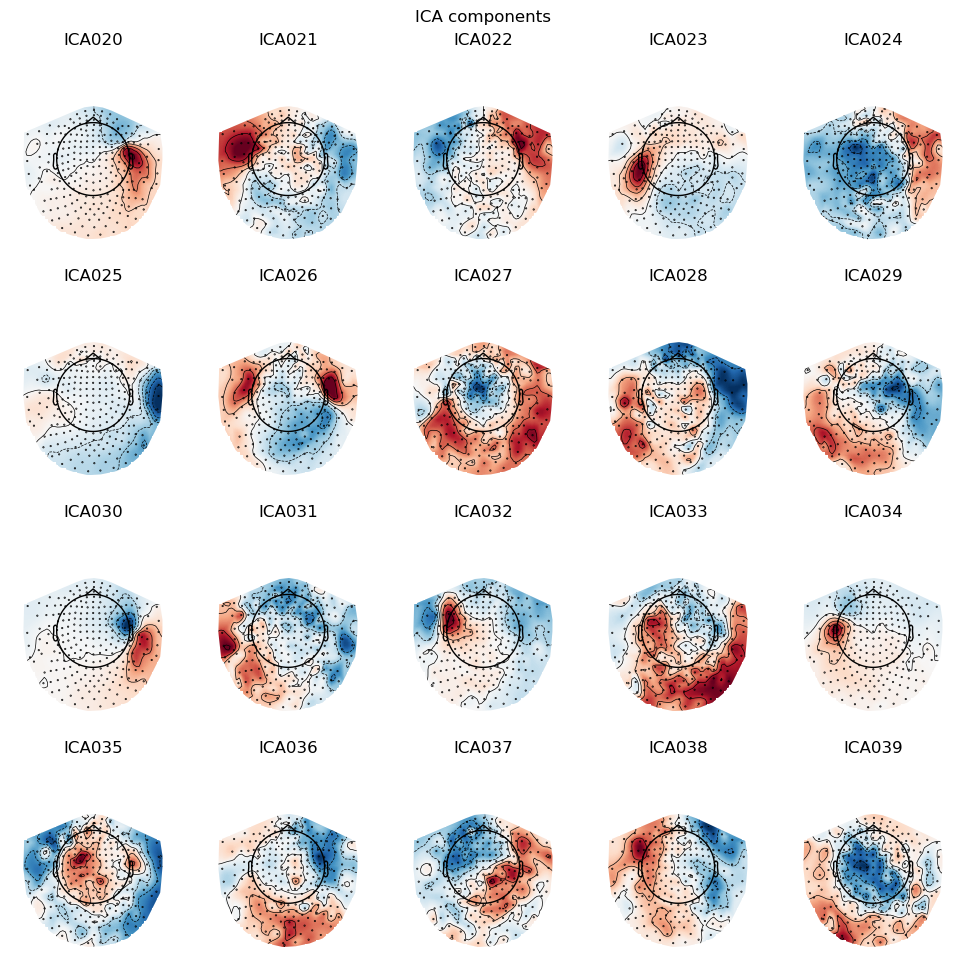

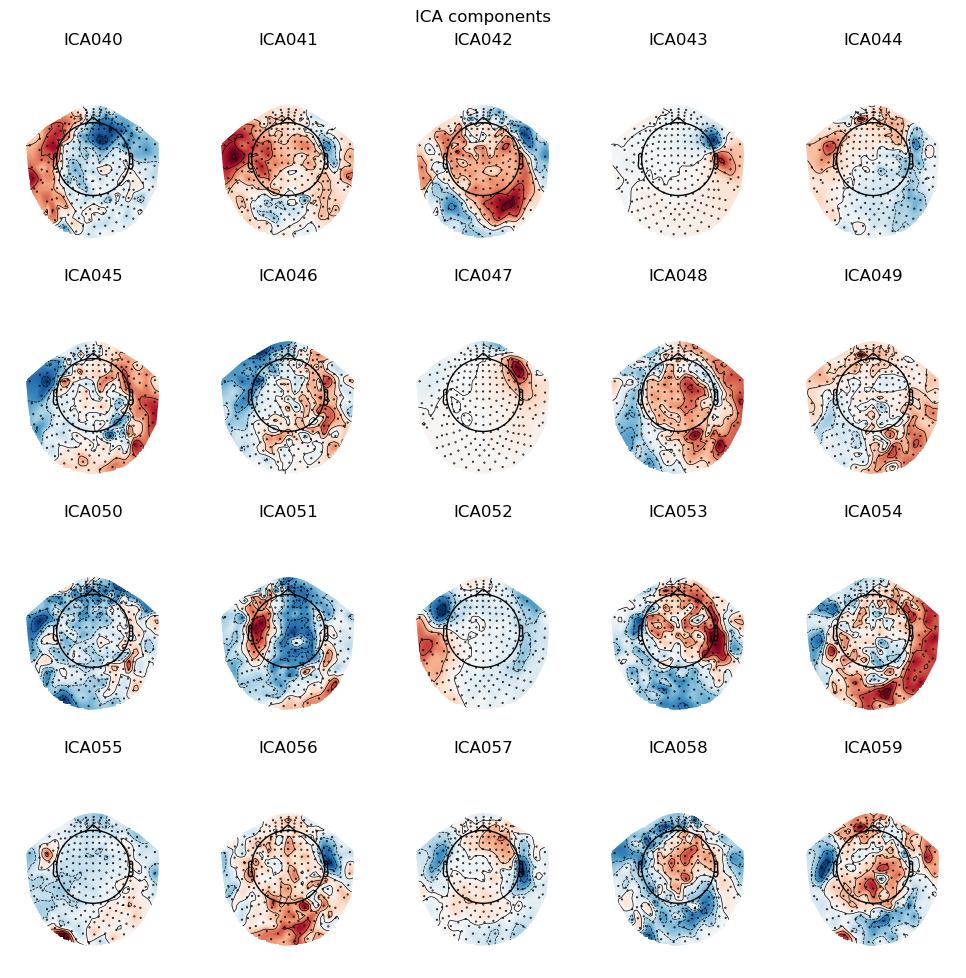

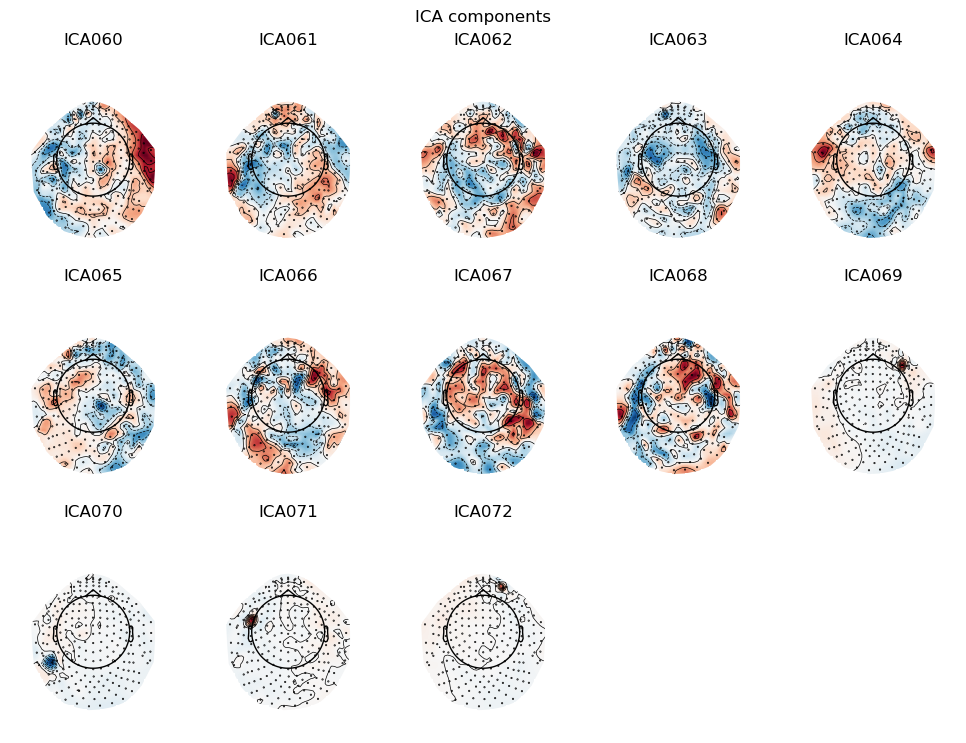

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x731.5 with 13 Axes>]

Creating RawArray with float64 data, n_channels=76, n_times=378958
    Range : 0 ... 378957 =      0.000 ...   757.914 secs
Ready.
Using qt as 2D backend.
Using pyopengl with version 3.1.6


2025-04-16 16:39:08.611 python[53935:1500610] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-16 16:39:08.611 python[53935:1500610] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Applying ICA to Raw instance
    Transforming to ICA space (73 components)
    Zeroing out 5 ICA components
    Projecting back using 245 PCA components


<RawBTi | c,rfDC, 284 x 378958 (757.9 s), ~821.7 MB, data loaded>

Applying ICA to Raw instance
    Transforming to ICA space (73 components)
    Zeroing out 5 ICA components
    Projecting back using 245 PCA components


<RawBTi | c,rfDC, 284 x 378958 (757.9 s), ~821.7 MB, data loaded>

In [33]:
print(bad_channels_subject)
print(bad_channels_empty_room)

['MEG 230', 'MEG 059', 'MEG 173']
['MEG 144', 'MEG 059', 'MEG 173']


In [34]:
bads_union = list(set(bad_channels_subject).union(set(bad_channels_empty_room))) # to be created, maybe save this as well.

In [35]:
bads_union

['MEG 059', 'MEG 230', 'MEG 144', 'MEG 173']

In [ ]:
resampled_raw.info['bads'] = bads_union
empty_room_recording.info['bads'] = bads_union

# bad_loc_channel = "MEG 173"

# resampled_raw.info['bads'].remove(bad_loc_channel)
# empty_room_recording.info['bads'].remove(bad_loc_channel)


In [ ]:
# save interpolation for later 
# resampled_raw.interpolate_bads()
# empty_room_recording.interpolate_bads(origin=(0.0, 0.0, 0.0))

Setting channel interpolation method to {'meg': 'MNE'}.
Setting channel interpolation method to {'meg': 'MNE'}.


/var/folders/f1/tvmmnqs17399g3n7wyy0pq0c0000gn/T/ipykernel_52653/3335031035.py:1: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  resampled_raw.interpolate_bads()
/var/folders/f1/tvmmnqs17399g3n7wyy0pq0c0000gn/T/ipykernel_52653/3335031035.py:2: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  empty_room_recording.interpolate_bads(origin=(0.0, 0.0, 0.0))


<RawBTi | c,rfDC, 280 x 90000 (180.0 s), ~192.5 MB, data loaded>